# Model-based Reinforcement Learning and Planning with Tabular Methods
## ST449 Deep Learning and Artificial Intelligence
### Student 10173 (GitHub @raptors18)

In [1]:
# basic
import numpy as np
import pandas as pd

# graphics
from IPython.display import Image
import matplotlib.pyplot as plt
import seaborn as sns

# set some options
%matplotlib inline
sns.set_style('darkgrid')

# reinforcement learning
import acme
from acme import types
from acme.environment_loop import EnvironmentLoop
from acme.utils.loggers import TerminalLogger, InMemoryLogger

# my code
from agents import SarsaAgent, QAgent, DynaQAgent, PrioirtySweepAgent
from environments import Maze
from policies import *
import utils

In [2]:
# for colab
# from dataframe import InMemoryLogger
# !pip install --upgrade pip setuptools
# !pip install dm-acme[reverb]
# !pip install dm-acme[tf]

## 1. Introduction

Reinforcement learning algorithms can be characterized as either *model-based* or *model-free*, depending on whether or not they rely on a model of the environment. The algorithms covered during the ST449 lectures and classes, such as SARSA, Q-learning, and TD($\lambda$), fall into the model-free category because they do not use such a model. In other words, they do not rely on any knowledge of how the environment works. Instead, they only require sampled experience in order to directly learn a control policy.

Often, however, it can be helpful to make use of knowledge about the environment because it gives the agent a useful ability: namely, the ability of *planning*. In some cases, such knowledge is naturally available. In chess, for example, it is known how each action affects the next state - these are just the rules of the game - and they can be used to construct a model.

In many other cases, however, knowledge about the environment is not naturally available. For example, we often simply do not know how an environment will react to certain actions because there is randomness or stochasticity involved. Nevertheless, a model can be useful. The main difference in this case, however, is that the model cannot be specified but must be learned by the agent.

Whether model-based methods or model-free methods are generally preferred is an open debate with probably no absolute answer. However, Atkeson and Santamaria (1997) find that

> "*model-based reinforcement learning is more data efficient than direct reinforcement learning, [...] finds better trajectories, plans, and policies, and [...] handles changing goals more efficiently*".

Model-based methods are also responsible for some of the most impressive recent achievements in the field of artificial intelligence. For example, DeepMind's AlphaGo and AlphaZero algorithms use a Monte Carlo tree search at their very core, which is a planning method (Silver et al, 2017). MCTS is the topic of chapter 5.3.

More generally, the goal of this project is to demonstrate how model-based reinforcement learning can be applied in a tabular setting (i.e. with a finite number of states and actions). I discuss how having a model of the environment naturally gives rise to the ability to "plan", and I show how this can lead to vastly better results than model-free methods. For that purpose, I implement several different model-free and model-based methods and compare their results on a simple, deterministic grid world environment. I also discuss and show how an agent can learn a model of the environment.

### Notebook Outline 

In **chapter 2**, I present the environment that I use throughout this notebook - a deterministic maze in which the goal of the agent is to walk from a start state to the goal state while avoiding several obstacles.

In **chapter 3**, I introduce Acme, a reinforcement learning research framework for implementing RL agents.

In **chapter 4**, I implement two model-free methods, *SARSA* and *Q-learning*, and apply them to the maze. The two algorithms provide the baseline results against which I can compare my model-based methods.

In **chapter 5**, the focus is on model-based reinforcement learning. I first discuss the concept of *planning*, why it may be useful, and why it requires a model of the environment. I then implement two seminal RL algorithms that rely on planning and a learned model: *dyna-Q* (chapter 5.1) and *prioritized sweeping* (chapter 5.2). I also discuss the *Monte Carlo tree search* algorithm and implement an agent that uses this algorithm (chapter 5.3).

Finally, **chapter 6** contains a summary and conclusion.

### Python Code

For the sake of readability, this notebook is mainly about presenting my results while most of the algorithms/agents themselves are written in separate files (see accompanying Python files).

***environments.py*** - implementation of the environment 
- `Maze`
   
***agents.py*** - implementations of all RL agents
- `SarsaAgent`
- `QAgent`
- `DynaQAgent`
- `PrioirtySweepAgent`
- `MCTSAgent`

***models.py*** - implementations of the environment models
- `Model`
- `PrioritySweepModel`

***policies.py*** - some policies that the agents use
- `random_policy`
- `epsilon_greedy`

***utils.py*** - additional helper functions

## 2. Maze Environment

I follow the problem setup proposed by Sutton and Barto (2018) in chapter 8. The authors propose a $6\times9$ maze with a start state, a single goal state, and several obstacles. The only reward that is achievable is a reward of $1$ for reaching the goal state. There is no penalty that depends on the number of steps taken.

In [4]:
env = Maze()
Q = np.zeros(env.q_size)

# print maze
utils.print_policy(env, Q, with_start=True)

[[^ ^ ^ ^ ^ ^ ^ | G]
 [^ ^ | ^ ^ ^ ^ | ^]
 [S ^ | ^ ^ ^ ^ | ^]
 [^ ^ | ^ ^ ^ ^ ^ ^]
 [^ ^ ^ ^ ^ | ^ ^ ^]
 [^ ^ ^ ^ ^ ^ ^ ^ ^]]


Above is a plot of the maze, where $S$ is the start state, $G$ is the goal state, and "$|$" are obstacles. The four possible actions in each state are
- $up = 0$ (^)
- $down = 1$ (v)
- $left = 2$ (<)
- $right = 3$(>)

Actions deterministically lead the agent to the logical next state (e.g. action left always results in the state to the left of the agent). However, the agent cannot fall off the edges of the maze or visit any of the obstacle states. If such an action is taken by the agent, its position simply does not change. Note that the above visualization of the maze shows the initial policy, which is to choose the first action (that is $up$) in each state, but this is not important at all.

The minimum number of steps required from start to goal is 14.

## 3. Acme: a Research Framework for Reinforcement Learning

Acme is a reinforcement learning research framework open sourced by Google DeepMind in 2020. It provides basic building blocks for the implementation of RL agents. These building blocks are essentially abstract Python base classes which determine a given structure and functionality. For a detailed description of these building blocks and the motivation behind the framework, see the following research paper published on arXiv.

[DeepMind (2020): _Acme: A Research Framework for Distributed Reinforcement Learning_.](https://arxiv.org/abs/2006.00979)

The library also provides some additional components such as wrappers for gym environments, an environment loop, and loggers. In addition, there are also a number of pre-implemented agents. While most of these agents are rely on TensorFlow or JAX, Acme is generally framework agnostic and can be integrated with any machine learning library.

I use Acme for this project for several reasons.
- **well thought through**: it is made by the most successful AI company in the world and is used there on a daily basis
- **generic structure**: the buildings blocks have been designed such that they work for any agent and environment
- **faster experimentation**: some convenient components are available which would otherwise have to be implemented from scratch; two examples are the *environment loop* and loggers

On the downside, the library is still quite new and a thorough documentation is lacking. Therefore, the pre-implemented agents sometimes have to serve as a substitute documentation.

### 3.1 Actors
In Acme, there is a distinction between *actors* and *learners* - combining them is what makes an RL *agent*. One of the main reasons for this distinction is to facilitate distributed reinforcement learning. If distributed learning is not important, however, it is often sufficient to work with an actor and simply integrate all learning steps, which is also the approach that I take.

For example, the random agent below inherits from the `acme.Actor` class. The methods to implement are `select_action`, `observe_first`, `observe`, and `update`, which is where the learning occurs. Note that the agent would work exactly the same way without subclassing `acme.Actor`. The base class simply determines the methods that must be be overwritten by any agent implementation.

In [5]:
class RandomAgent(acme.Actor):
    
    def __init__(self):
        
        # init action values, will not be updated by random agent
        self.Q = np.zeros((6,9,4))
        
        # specify the behavior
        self.behavior = random_policy
        
        # store timestep, action, next_timestep
        self.timestep = None
        self.action = None
        self.next_timestep = None
        
    
    def select_action(self, observation):
        "Choose an action according to the behavior policy."
        return self.behavior(self.Q[observation])    

    def observe_first(self, timestep):
        "Observe the first timestep of the trajectory."
        self.timestep = timestep

    def observe(self, action, next_timestep):
        "Observe the next timestep."
        self.action = action
        self.next_timestep = next_timestep
        
    def update(self):
        "Update the policy."
        # only set timestep to next_timestep, no updates here
        self.timestep = self.next_timestep

### 3.2 Environment Loop

Reinforcement learning typically consists of the following steps, no matter the environment or type of agent used.

1. the agent observes a state
2. takes an action
3. observes a reward and next state
4. performs an update on the policy 

These steps are repeated until a terminal state is reached, which constitutes a single episode. For multiple episodes, a plain for loop is used. The code chunk below is an simulation of 10 episodes using the maze environment and the random agent.

In [6]:
# first initialize env and agent
env = Maze()
agent = RandomAgent()

# repeat for a number of episodes
for episode in range(10):

    # make first observation
    timestep = env.reset()
    agent.observe_first(timestep)

    # run an episode
    while not timestep.last():

        # generate an action from the agent's policy
        action = agent.select_action(timestep.observation)
        
        # step the environment
        timestep = env.step(action)

        # have the agent observe the timestep
        agent.observe(action, next_timestep=timestep)
        
        # let the agent update itself
        agent.update()

Since this loop is so standard across RL problems, it can be easily turned into a function. Indeed, there is a pre-built `EnvironmentLoop` in Acme which does exactly that. It can be used to run either a single episode ...

In [7]:
# using Acme's environment loop
loop = EnvironmentLoop(env, agent, logger=InMemoryLogger())
loop.run_episode()

{'episode_length': 381,
 'episode_return': array(1.),
 'episodes': 1,
 'steps': 381,
 'steps_per_second': 20983.36100424124}

... or any number of episodes

In [8]:
# run 100 episodes
loop.run(100)

In addition, a logger can be used to track metrics such as the length of each episode and the total number of steps taken.

In [9]:
loop._logger.to_dataframe()

,episode_length,episode_return,steps_per_second,episodes,steps
0,333,1.0,19006.126689,2,714
1,1161,1.0,42260.815121,3,1875
2,603,1.0,41706.495696,4,2478
3,861,1.0,40808.829444,5,3339
4,283,1.0,43874.770163,6,3622
...,...,...,...,...,...
95,473,1.0,35258.780315,97,82329
96,1063,1.0,43645.331088,98,83392
97,612,1.0,46373.530757,99,84004
98,664,1.0,46387.585463,100,84668


Of course, this was just a random agent that does not learn. The plot below shows the number of steps the agent takes until it finds (or rather stumbles across) the goal state. The step counts range from the theoretical minimum of 14 steps to a few thousand steps, although it is quite unlikely that the random agent actually achieves the minimum.

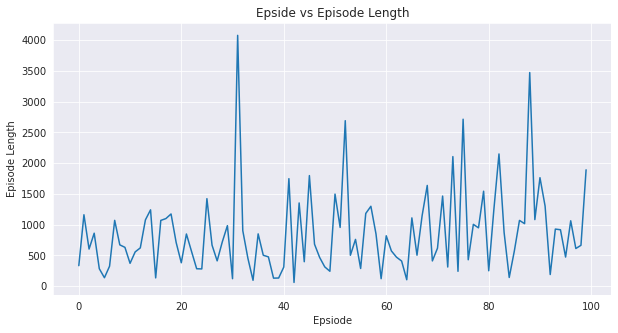

In [10]:
df = loop._logger.to_dataframe()
utils.plot_episode_len(df)

## 4. Model-Free Reinforcement Learning

Before the focus turns to model-based reinforcement learning and planning, I first implement two model-free algorithms which do not rely on any form on planning. The two methods are SARSA and Q-Learning. Their main goal is to establish some baseline results against which I will compare any model-based methods later on.

### 4.1 SARSA

In [14]:
env = Maze()
sarsa = SarsaAgent(epsilon=0.1)

# run for 50 episodes
sarsa_loop = EnvironmentLoop(env, sarsa, logger=InMemoryLogger())
sarsa_loop.run(50)

# print resulting policy
utils.print_policy(env, sarsa.Q)

[[^ ^ ^ ^ ^ ^ v | G]
 [^ ^ | ^ ^ ^ v | ^]
 [v < | ^ v < v | ^]
 [v < | > > > > > ^]
 [> > > > ^ | ^ ^ ^]
 [^ ^ ^ > ^ ^ ^ ^ ^]]


The policy found after 50 episodes is not too far from being optimal, but it is certainly not optimal in all states. Some states have simply not been visited often enough. There is, however, an optimal path from the start to the goal state.

A single run of the experiment is not very representative, however - the agent may stumble across the goal especially early or late in a given run. Therefore, I repeat the experiment 100 times and plot the average episode length (or step count) against the episode number.

In [ ]:
def repeat_loop(env, agent, repeat=100, episodes=50):

    dfs = []

    for i in range(repeat):
        myagent = agent()
        loop = EnvironmentLoop(env, myagent, logger=InMemoryLogger())
        loop.run_episode()
        loop.run(episodes)
        dfs.append(loop._logger.to_dataframe())

    return dfs 

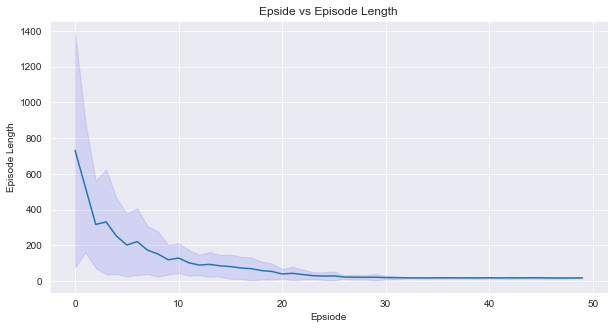

In [ ]:
env = Maze()
agent = SarsaAgent

# repeat the loop
res = repeat_loop(env, agent)
utils.plot_episode_len_std(res)

During the first few episodes, the agent takes a few hundred steps on average until it can find the goal state. This is because initially, the agent does not have any reliable action value estimates so it behaves (almost) randomly. The more episodes the agent accumulates, however, the more reliable its action values and thus its action choices get. In fact, Monte Carlo methods are guaranteed to eventually converge to the true action values, provided that all states are visited often enough.

In most runs, the agent finds an optimal policy (or rather optimal path from start to goal) between episodes 20 and 30. Note that the average number of steps will always be slightly higher than the minimum of 14 because of the $\epsilon$-greedy action selection. This could be avoided by decreasing (decaying) $\epsilon$ over time, but I do not do that here.

The blue area in the plot marks a one standard deviation interval, which gives an idea of how much the step counts vary.

### 4.2 Q-Learning

In [ ]:
env = Maze()
qagent = QAgent()

# run for 50 episodes
qagent_loop = EnvironmentLoop(env, qagent, logger=InMemoryLogger())
qagent_loop.run(50)

# print resulting policy
print_policy(env, qagent.Q)

[[^ ^ ^ ^ ^ ^ ^ | G]
 [^ v | ^ ^ v ^ | ^]
 [> v | > > v < | ^]
 [> v | v > > > > ^]
 [> > > > ^ | ^ ^ ^]
 [^ > ^ > ^ > ^ ^ ^]]


Like with SARSA before, this policy is not optimal in all states, but clearly better than random. Also, if we only cared about the path from start to goal, the policy would again be optimal.

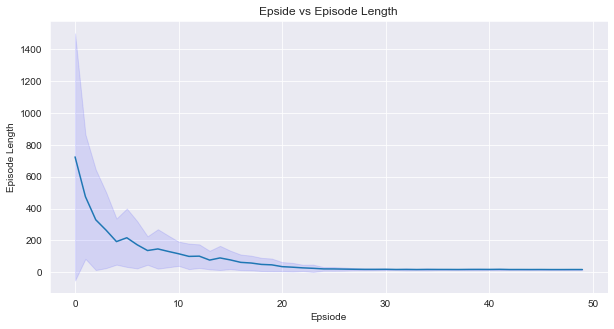

In [ ]:
env = Maze()
agent = QAgent

# repeat the loop and plot
res = repeat_loop(env, agent)
utils.plot_episode_len_std(res)

The average results over 100 simulations are very similar to those obtained by the SARSA agent. Note that the interval includes step counts of less than 0 for the first episode(s). This would be a wrong conclusion however. The reason is simply that the variance towards a very large step counts is very high.

## 5. Model-Based Reinforcement Learning

In reinforcement learning, we can differentiate between *model-free* and *model-based* methods. While model-free methods rely on learning, model-based methods rely on planning. Unlike model-free RL, planning requires a model of the environment. This model may be known or learned.

Generally speaking, a model can be anything that makes predictions about the underlying MDP dynamics, i.e. about $p(s',r|s,a)$. The model can either be

-   a **distribution model** for $p(s',r|s,a)$ for all $s,a,r,s'$, or
-   a **sample model** that only allows sampling $s',r$ when in $(s,a)$.

While the former is more general, the latter is typically more feasible in practice.

#### Planning
A model - be it a distribution or sample model, be it known or learned - can be used to produce *simulated experience* from which an agent can learn just as if it was real experience. This is what is known as *(background) planning* in reinforcement learning. 

In other words, while planning uses real experience generated by the environment, planning uses simulated experience generated by the model. Planning is therefore also known as *indirect reinforcement learning* while learning is also called *direct reinforcement learning*. The image below from Sutton and Barto (2018) illustrates these relationships.

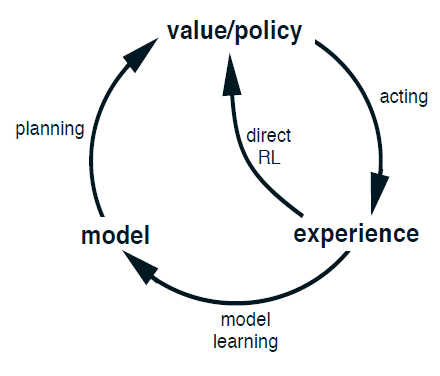

In [ ]:
Image('images/planning.png', width=300)

*Dynamic programming* techniques such as policy iteration and value iteration can be seen as pure planning (= model-based) methods using a known distribution model. In contrast, *Monte Carlo methods* do not rely on any model of the environment and are therefore considered model-free. The two algorithms presented above, SARSA and Q-Learning, are Monte Carlo methods and thus fall into the model-free category. 

However, it is important to note that model-free and model-based methods are not mutually exclusive. In fact, planning can be effectively combined with learning, which can lead to better algorithms. The purpose of this chapter is to show how that can be done.

### 5.1 Dyna-Q

Dyna-Q is an important online algorithm that integrates planning, acting and learning. Learning (direct RL) is achieved through one-step tabular Q-learning. Planning (indirect RL), relies on a learned model of the environment.

#### Model Learning

How to learn a model of the environment depends on general RL setup at hand. In the non-tabular case (states are vectors), it usually involves a statistical model such as a neural network, whose objective is to predict the next state and the immediate reward.

If there is a finite number of states and actions (the tabular case) and if the environment is deterministic, learning a model reduces to memorizing all the transitions that are observed by an agent. This is exactly what my implementation of an environment model for the Dyna-Q agent does (see *models.py* file). To demonstrate this, in the code cell below, I simulate 10 environment steps and show what the model has learned up to that point.

In [ ]:
from models import Model

# first initialize env and agent
env = Maze()
model = Model()

# make first observation
timestep = env.reset()

# run an episode
for i in range(10):

    # generate an action from the agent's policy and step the environment
    action = np.random.choice(4)
    next_timestep = env.step(action)
    
    # update the model
    model.update(timestep.observation, action, next_timestep.observation, next_timestep.reward)
    
    timestep = next_timestep
    
model.model

{(2, 0): {0: ((1, 0), 0.0)},
 (1, 0): {3: ((1, 1), 0.0)},
 (1, 1): {0: ((0, 1), 0.0)},
 (0, 1): {0: ((0, 1), 0.0), 3: ((0, 2), 0.0)},
 (0, 2): {3: ((0, 3), 0.0)},
 (0, 3): {1: ((1, 3), 0.0)},
 (1, 3): {2: ((1, 3), 0.0), 1: ((2, 3), 0.0)},
 (2, 3): {2: ((2, 3), 0.0)}}

For example, the model has learned that taking action 0 (up) in state $(2,0)$ leads to the state $(1,0)$ and an immediate reward of 0.

Of course, after many episodes, we would expect the agent to have learned all possible transitions (as long as there is sufficient exploration, of course). Also note that because the environment is deterministic, the learned model will always be totally correct, i.e. there is no estimation bias due to the deterministic nature of the environment.

If, in contrast, the model is a learned parameterized function (such as a neural network), it will not be perfect, or might even be wrong. In fact, how well model-based RL methods perform hugely depends on the quality of the model.

#### Dyna-Q-style Planning

Dyna-Q-style planning proceeds as follows. Given a model, a state-action pair is sampled uniformly at random from all previously seen pairs. The model is then used to simulate a trajectory of experience starting from this state-action pair. 

The rewards predicted by the model along the way are used to update the value function as if they came from real experience. Typically, the same learning method an agent uses for direct reinforcement learning is also used during planning, which in this case is one-step tabular Q-learning (hence the Q in Dyna-Q). Conceptually, planning, acting, model-learning, and direct RL all occur in parallel. However, in an actual implementation, they usually occur sequentially.

#### Two Episodes without Planning

In [ ]:
env = Maze()
dyna_qagent = DynaQAgent(planning_steps=0)

# run for only two episodes
dyna5_loop = EnvironmentLoop(env, dyna_qagent, logger=InMemoryLogger())
dyna5_loop.run(2)

# print resulting policy
print('Policy without planning after 2 episodes')
print_policy(env, dyna_qagent.Q)

Policy without planning after 2 episodes
[[^ ^ ^ ^ ^ ^ ^ | G]
 [^ ^ | ^ ^ ^ ^ | ^]
 [^ ^ | ^ ^ ^ ^ | ^]
 [^ ^ | ^ ^ ^ ^ ^ ^]
 [^ ^ ^ ^ ^ | ^ ^ ^]
 [^ ^ ^ ^ ^ ^ ^ ^ ^]]


Without planning, two episodes are simply way too few. In fact, only the two states preceding the goal state have received any updates at this point since we are using one-step Q-learning. In all other states, the agent is essentially clueless about which actions are good or bad. Also note that with zero planning steps, this algorithm is equivalent to plain Q-learning and the `QAgent` above.

#### Two Episodes with Planning

In [17]:
env = Maze()
dyna_qagent = DynaQAgent(planning_steps=50)

# run for only 3 episodes
dyna50_loop = EnvironmentLoop(env, dyna_qagent, logger=InMemoryLogger())
dyna50_loop.run(2)

# print resulting policy
print('Policy with 50 planning steps after 2 episodes')
utils.print_policy(env, dyna_qagent.Q)

Policy with 50 planning steps after 2 episodes
[[> > > > > > v | G]
 [^ ^ | > v > v | ^]
 [v v | v > v v | ^]
 [> v | > > > > > ^]
 [> > > > ^ | > > ^]
 [> ^ ^ ^ ^ > ^ ^ <]]


Using 50 planning steps and only two episodes, the learned policy is already very close to an optimal policy. There are only a few states in which the action is still sub-optimal (e.g. the bottom right state). Planning seems to be highly effective here (see later for more details on why this is the case).

#### Number of Planning Steps
So how many planning steps should be used? In order to find out, I compare the average results of 100 runs with planning step sizes 0 (no planning), 5 and 50.

Wall time: 4min 6s


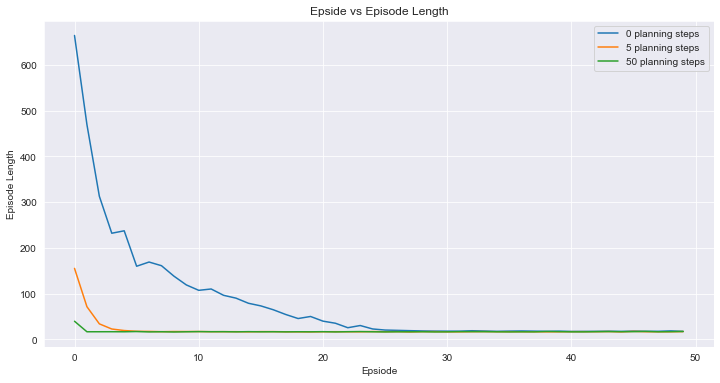

In [ ]:
%%time

env = Maze()

# plot
fig, ax = plt.subplots(figsize=(12,6))
for i in [0, 5, 50]:
    dfs = []
    for _ in range(100):
        myagent = DynaQAgent(planning_steps=i)
        loop = EnvironmentLoop(env, myagent, logger=InMemoryLogger())
        loop.run_episode()
        loop.run(50)
        dfs.append(loop._logger.to_dataframe())

    df = pd.concat(dfs).groupby(level=0).mean()
    plt.plot(df['episode_length'], label=f'{i} planning steps')

plt.title('Epside vs Episode Length')
plt.xlabel('Epsiode')
plt.ylabel('Episode Length')
plt.legend();

First of all, we can see that Dyna-Q, with both 5 and 50 planning steps, vastly outperforms plain Q-learning (0 planning steps). Without planning, it takes the agent on average between $20$ and $30$ episodes to converge to an optimal policy. With five planning steps, it takes only around 5 episodes, and with $50$ planning steps, even fewer than 5. 

Second, a larger number of planning steps appears to be better than a smaller number. While this may not always be the case, it is easy to explain this vast improvement here. As already mentioned, whether planning is helpful or not primarily depends on how good the learned model of the environment is. In this deterministic environment, the agent can learn a perfect model. As a result, any simulated experience (=planning) is as good as real experience. This is why planning is so effective in this case. If the model is imperfect or even wrong, however, planning can also be harmful.

### 5.2 Prioritized Sweeping

The above Dyna-Q agent samples states-action pairs uniformly at random from all previously seen pairs. This is quite inefficient, however, since most pairs do not change most of the time. Especially in the beginning, only states close to the goal state will see any value updates. It would be better to select state-action pairs based on these value updates and their magnitude because a large value update means that also neighboring states will likely have to change significantly as a result. This is why it makes sense to prioritize these states, which is exactly the idea behind prioritized sweeping.

#### Priority Queues
In order to implement prioritized sweeping, the concept of a priority queue is typically used. To demonstrate this, the below priority queue is first filled with three elements ($code,eat,sleep$) and their corresponding priority scores. The elements can then be easily and efficiently extracted from from the queue in the order of their priority (the default is from lowest to highest, however).

In [ ]:
import heapq

priority_queue = []

heapq.heappush(priority_queue, (1, 'code'))
heapq.heappush(priority_queue, (2, 'eat'))
heapq.heappush(priority_queue, (0, 'sleep'))

while priority_queue:
    next_item = heapq.heappop(priority_queue)
    print(next_item)

(0, 'sleep')
(1, 'code')
(2, 'eat')


#### Results

In [27]:
env = Maze()
ps_qagent = PrioirtySweepAgent(planning_steps=50)

# run for only 5 episodes
ps_loop = EnvironmentLoop(env, ps_qagent, logger=InMemoryLogger())
ps_loop.run(5)

# print resulting policy
utils.print_policy(env, ps_qagent.Q)

[[^ ^ > > v > v | G]
 [^ ^ | v v v v | ^]
 [^ ^ | > > v v | ^]
 [> v | > > > > > ^]
 [> > > > ^ | > > ^]
 [> > > > > > > ^ ^]]


After only five episodes, the policy is already quite good, even though there are still some states in which a sub-optimal action is chosen.

#### Number of Planning Steps
As before, in order to visualize the dependency of the agent's performance on the number of planning steps, I run the algorithm with 0, 5 and 50 planning steps, averaged over 100 runs.

Wall time: 7min 49s


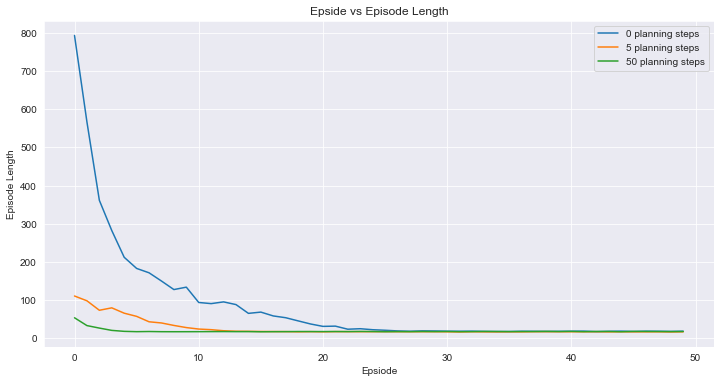

In [ ]:
%%time

env = Maze()

fig, ax = plt.subplots(figsize=(12,6))
for i in [0, 5, 50]:
    
    dfs = []
    
    for _ in range(100):
        myagent = PrioirtySweepAgent(planning_steps=i)
        loop = EnvironmentLoop(env, myagent, logger=InMemoryLogger())
        loop.run_episode()
        loop.run(50)
        dfs.append(loop._logger.to_dataframe())

    df = pd.concat(dfs).groupby(level=0).mean()
    plt.plot(df['episode_length'], label=f'{i} planning steps')

plt.title('Epside vs Episode Length')
plt.xlabel('Epsiode')
plt.ylabel('Episode Length')  
plt.legend();

Again, the results prove that planning clearly helps the agent learn faster as compared to the model-free methods SARSA and Q-learning. Also, a larger number of planning steps seems to provide an advantage over a lower number of steps. The reasons are the same as for Dyna-Q (perfect model of the environment).

#### Comparison between Dyna-Q and Prioritized Sweeping
One might expect prioritized sweeping to perform even better than Dyna-Q, as the former is essentially a more sophisticated version of the latter. Indeed, prioritized sweeping is generally preferred due to the more selective choice of states during planning. That means, planning is more focused on those states that are most important while other areas of the environment are simply ignored. This can be very helpful since often only a small part of the environment is actually relevant to the agent, the rest is simply not worth exploring too much (for example, think of states that are far away from the agent's optimal path).

In this small maze environment, however, the advantage of prioritized sweeping over Dyna-Q is simply too small, if not negligible. Even randomly chosen states are not too far from the most important areas of the environment and thus it is likely that most planning steps will lead to some useful updates in those important regions.

### 5.3 Decision-Time Planning & Monte Carlo Tree Search

The two planning methods considered so far, Dyna-Q and prioritized sweeping, perform what is known as *background planning*. That means, planning is not focused on the the agent's current state but instead, simulated experience is used to gradually improve the overall value function and thereby the policy. Indeed, both Dyna-Q and prioritized sweeping pick states anywhere in the environment for planning: while Dyna-Q selects states uniformly at random, prioritized sweeping focuses on high priority states, which are nevertheless independent of the agent's current state.

In contrast, *decision-time planning* begins when the agent encounters a state and is focused on just that state. It can be thought of as "looking ahead" for as many steps as possible within a certain computational budget. Accordingly, decision time planning is most useful when the agent has some time to "think" (i.e. plan ahead) and is not required to make fast decisions. In chess, for example, players typically get 60 seconds to make a move, which an agent can use for decision-time planning. For quick decisions, by contrast, background planning is usually better suited.

Decision-time planning is very powerful because of its focus on the agent's current state. To illustrate its idea, consider a basic breadth-first search. If the agent can simply plan ahead far enough (until the goal state), it will always be able to choose the best action. However, an exhausting depth-first search is infeasible even for only a small number of states. Therefore, not only a better way to build a search tree is needed, but also a way to estimate certain branches of the tree without having to expand them until the terminal state. This is where the Mote Carlo aspect comes in.

#### Monte Carlo Tree Search

Monte Carlo tree search is probably the planning method that has received the most attention in recent years. It is the key component in DeepMind's famous AlphaGo and AlphaZero algorithms (Silver et al, 2017).

At its core, MCTS is a *rollout algorithm*. Rollout algorithms use simulated trajectories (i.e. rollouts) to estimate the action values of the current policy. Unlike direct RL algorithms such as SARSA and Q-learning, however, the goal is not to estimate the full action value function, but only the action values for the agent's current state.

As usual with Monte Carlo methods, the more trajectories are sampled, the more accurate the estimates will be. Therefore, they will usually be more accurate than any action values estimated otherwise by the agent (e.g. through temporal difference learning). Accordingly, acting greedily with respect to these estimates will (usually) imply an improvement over the current policy. This is due to the policy improvement theorem.

Importantly, the goal of rollout algorithms is not to find an optimal policy but only to improve upon the current policy. In fact, the action values computed are typically only used once and discarded thereafter (i.e. they are not used to back up action values). For this reason, rollout algorithms are not ordinarily considered *learning* algorithms.

> "*At its base, MCTS is a rollout algorithm as described above, but enhanced by the addition of a means for accumulating value estimates obtained from the Monte Carlo simulations in order to successively direct simulations toward more highly-rewarding trajectories*" (Sutton and Barto, 2018).

In its most basic form, MCTS comprises four steps.

1. **Selection**: a *tree policy* is used to choose the next node (i.e. state) of the search tree, usually while balancing exploration and exploitation; common tree policies are $\epsilon$-greedy and UCB
2. **Expansion**: the tree is expanded from the new node to one or more child nodes
3. **Simulation**: simulations of complete episodes are run starting from the child node(s) using a *rollout policy*
4. **Backup**: the generated returns are used to update the action values of the tree nodes

The four steps are illustrated by Sutton and Barto (2019).

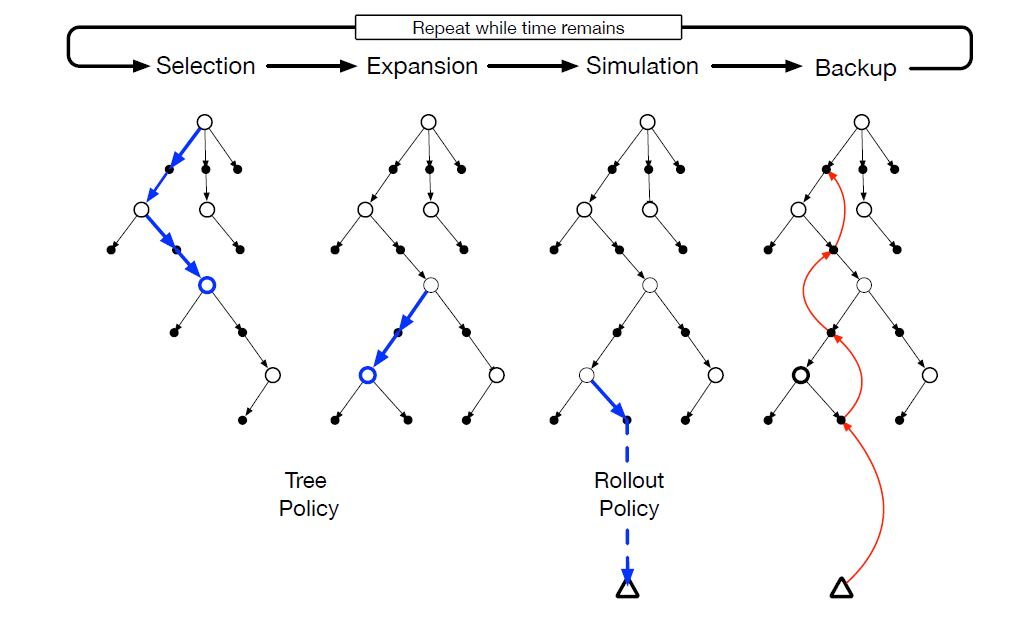

In [ ]:
from IPython.display import Image
Image('images/mcts.jpg', width=700)

MCTS can take on many different flavors, depending not only on the tree and rollout policies used - also other bells and whistles are sometimes included.

>"*While the basic algorithm [...] has proved effective for a wide range of problems, the full benefit of MCTS
is typically not realised until this basic algorithm is adapted to suit the domain at hand*" (Browne et all, 2012).


#### Implementation

While conceptually quite simple, implementing a Monte Carlo tree search is very elaborate and could probably be a project by itself. Therefore, I focus on the implementation of the agent here and use the MCTS algorithm pre-implemented in Acme. This particular implementation of the MCTS is part of DeepMind's AlphaZero algorithm (i.e. this is one of the pre-implemented agents in Acme). The authors/developers ([link](https://github.com/deepmind/acme/tree/master/acme/agents/tf/mcts)) describe it as "*a scaled-down and simplified version of the AlphaZero algorithm*" that works with a known or learned model. 

My implementation assumes a known model. This is unlike the RL methods before (both Dyna-Q and prioritized sweeping learned their models). In practice, having a known model means that we can simply use the environment itself (or rather a copy thereof) for planning. Within my `MCTSAgent` (see *agents.py*) you therefore find the expression `self.model = Simulator(Maze())`, where `Simulator` is an Acme environment wrapper which is used to simulate experience as a subroutine of the MCTS.

The results below show that the `MCTSAgent` performs better than both SARSA and Q-learning, but not quite as well as dyna-Q and prioritized sweeping. As already mentioned, MCTS often needs to be adapted to the problem at hand in order to achieve its full potential. This particular implementation of the MCTS algorithm was developed for AlphaZero with the intention to play Chess, Go, and Shogi. It is therefore not surprising that it does not perform perfectly well on the very different, much smaller, and tabular maze environment. That being said, however, the positive effect of planning is still obvious.

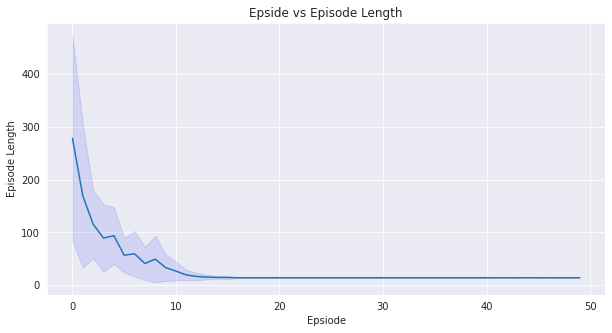

In [ ]:
env = Maze()
agent = MCTSAgent

# repeat the loop
res = repeat_loop(env, agent, repeat=50)
utils.plot_episode_len_std(res)

Note that once the MCTS agent has found the optimal path, each subsequent episode has the minimum number of steps, which is 14. This is not true for any of the previous algorithms since they use an $\epsilon$-greedy action selection. In fact, even when the optimal path is known, the probability that an $\epsilon$-greedy agent ($\epsilon=0.1$) takes the optimal action 14 times in a row (i.e. acts greedily 14 times) is $0.9^{14}=0.23$.

# 6. Conclusion

The objective of my project is to discuss and demonstrate model-based reinforcement learning and planning in a tabular setting. I implement five different algorithms - two model-free and three model-based algorithms - and apply them to a deterministic $6\times9$ maze environment with obstacles. For the implementation of my agents, I use Acme, a lightweight RL research framework open sourced by Google DeepMind in 2020. The framework is based on object oriented programming principles, determines a useful base structure for agents, and provides some convenient additional components. All of this not only allows faster experimentation, but also increases the readability and reproducibility of my code.

The five algorithms I implement are

- SARSA - model-free (on-policy)
- Q-learning - model-free (off-policy)
- Dyna-Q - model-based (off-policy)
- Prioritized Sweeping - model-based (off-policy)
- Monte Carlo Tree Search - model-based (does not learn action values)

**SARSA** and **Q-learning**, which are model-free methods, provide the baseline results. They are able to solve the maze (i.e. find an optimal policy), but this takes them on average between 20 to 30 episodes. 

**Dyna-Q**, a simple yet important RL algorithm that integrates planning, acting, and learning, requires less than 10 episodes on average to find the optimal policy. The improvement is due to the background planning, which the agent can do because it learns a model of the environment. In a deterministic setup, model learning reduces to memorizing all previous transitions and rewards. Since the learned model is perfect, planning proves to be highly effective, which explains the vast improvement over the model-free methods.

**Prioritized sweeping** differs from dyna-Q in that it chooses the states for background planning more selectively. That is, it chooses them based on a priority score that is proportional to the magnitude of the states' most recent action value updates. The implementation relies on a priority queue, which is a very efficient data structure that is commonly used to insert and extract elements from a queue in the order of their priority scores. The results obtained by my prioritized sweeping agent are quite similar to those obtained by Dyna-Q. In bigger, more complicated environments with large regions of the environment that are quite irrelevant for the agent, prioritized sweeping is typically preferred over Dyna-Q.

I also showed that both Dyna-Q and prioritized sweeping perform better with 50 planning than with only 5 planning steps. I have already pointed out the reason multiple times, but to repeat this important point: the vast effectiveness of planning in this scenario is due to the fact the learned model is perfect. As a result, any simulated experience (i.e. planning) is essentially as useful as real experience. In this sense, it is only logical that more planning leads to better results.

Finally, I also discuss decision-time planning and particularly the **Monte Carlo tree search** because of its huge impact on the field of reinforcement learning and artificial intelligence more broadly. MCTS is conceptually simple but is often adapted to suit the problem domain at hand. The positive effect of planning is again very obvious, even though the results cannot quite match those obtained by Dyna-Q and prioritized sweeping.

## References

Sutton and Barto (2018): *Reinforcement Learning: An Introduction*.

Silver et al (2018): *Mastering Chess and Shogi by Self-Play with a General Reinforcement Learning Algorithm*. Science Magazine.

Atkeson and Santamaria (1997): *A Comparison of Direct and Model-Based Reinforcement Learning*. International Conference on Robotics and Automation.

DeepMind (2020): *Acme: A Research Framework for Distributed Reinforcement Learning*.

Browne et al (2012): *A Survey of Monte Carlo Tree Search Methods*. IEEE Transactions on Computational Intelligence and AI in Games.

Janner (2019): *Model-Based Reinforcement Learning: Theory and Practice*. [Blog Post](https://bair.berkeley.edu/blog/2019/12/12/mbpo/)
